In [1]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"


/Users/csuarezgurruchaga/Desktop/Digital-House/CLASE_31/dsad_2021/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
Running command `conda install --yes nltk=3.5.0`... ok
Solving environment: ...working... done

# All requested packages already installed.


unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


<img src="../../../common/logo_DH.png" align='left' width=50%/>

### Desafío Clustering de Jugadores de Fifa

En esta práctica trabajaremos con un dataset de jugadores de Fifa18. El Fifa es un juego de consola en donde los jugadores de la principales ligas del mundo están descriptos por un conjunto de características como la agilidad, precisión en los tiros libres, etc, además de otros datos como la edad, nacionalidad, salario, y otros sobre su posición en el campo de juego. El dataset está disponible [acá](https://www.kaggle.com/thec03u5/fifa-18-demo-player-dataset). Lamentablemente, contamos con la versión del 2018 en donde pusieron a Cristiano Ronaldo en la tapa, pero cabe mencionar 

Algunas features del dataset son las siguientes:

* Name
* Age 
* Nationality
* Club
* Value: Precio de mercado del jugador
* Wage: Salario del jugador

(...)

* Acceleration
* Agility     
* Balance     
* Ball control
* Free kick accuracy

(...)

* CAM
* CB
* CDM
* CF
* CM                 

Estas últimas codifican numéricamente cuán bien se desenvuelven en las distintas posiciones del campo

<img src='img/field_positions.jpg' width=80%>



<b>El objetivo</b> de esta práctica es ver si hay alguna estructura de clusters en los datos y luego inferir qué criterio es el que mejor los agrupa.

Empezamos levantando el dataset.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
data=pd.read_csv('../Data/Fifa_players.csv', low_memory=False)

###  Limpieza

* ¿Qué tipo de datos tiene el dataset?

* Conviertan a numérica la columna 'Valor' eliminando el caracter "€" y transformando las M en millones y K en miles.

* Eliminen los jugadores con valor = 0. 

Vamos a implementar un algoritmo de clustering sobre la porción de las features que describen las habilidades de los jugadores. 

* Creen un nuevo dataframe seleccionando las columnas

['Acceleration', 'Aggression', 'Agility', 'Balance',
       'Ball control', 'Composure', 'Crossing', 'Curve', 'Dribbling',
       'Finishing', 'Free kick accuracy', 'GK diving', 'GK handling',
       'GK kicking', 'GK positioning', 'GK reflexes', 'Heading accuracy',
       'Interceptions', 'Jumping', 'Long passing', 'Long shots', 'Marking',
       'Penalties', 'Positioning', 'Reactions', 'Short passing', 'Shot power',
       'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle',
       'Strength', 'Vision', 'Volleys']
       
* Conviertan las columnas seleccionadas a tipo numérico, eliminando las filas que sean conflictivas, por ejemplo entradas como '50+8'.       
       
* <b>Importante:</b>No pisen el dataframe original y conserven la relación de índices entre ambos pues vamos a querer recuperar información del dataframe completo para evaluar la composicion de los clusters. 

In [4]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
     display(data.head(3))
     display(data.dtypes)

,Unnamed: 0,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,Wage,Special,Acceleration,Aggression,Agility,Balance,Ball control,Composure,Crossing,Curve,Dribbling,Finishing,Free kick accuracy,GK diving,GK handling,GK kicking,GK positioning,GK reflexes,Heading accuracy,Interceptions,Jumping,Long passing,Long shots,Marking,Penalties,Positioning,Reactions,Short passing,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys,CAM,CB,CDM,CF,CM,ID,LAM,LB,LCB,LCM,LDM,LF,LM,LS,LW,LWB,Preferred Positions,RAM,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
0,0,Cristiano Ronaldo,32,https://cdn.sofifa.org/48/18/players/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Real Madrid CF,https://cdn.sofifa.org/24/18/teams/243.png,€95.5M,€565K,2228,89,63,89,63,93,95,85,81,91,94,76,7,11,15,14,11,88,29,95,77,92,22,85,95,96,83,94,23,91,92,31,80,85,88,89.0,53.0,62.0,91.0,82.0,20801,89.0,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,ST LW,89.0,61.0,53.0,82.0,62.0,91.0,89.0,92.0,91.0,66.0,92.0
1,1,L. Messi,30,https://cdn.sofifa.org/48/18/players/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,93,93,FC Barcelona,https://cdn.sofifa.org/24/18/teams/241.png,€105M,€565K,2154,92,48,90,95,95,96,77,89,97,95,90,6,11,15,14,8,71,22,68,87,88,13,74,93,95,88,85,26,87,73,28,59,90,85,92.0,45.0,59.0,92.0,84.0,158023,92.0,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,RW,92.0,57.0,45.0,84.0,59.0,92.0,90.0,88.0,91.0,62.0,88.0
2,2,Neymar,25,https://cdn.sofifa.org/48/18/players/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,94,Paris Saint-Germain,https://cdn.sofifa.org/24/18/teams/73.png,€123M,€280K,2100,94,56,96,82,95,92,75,81,96,89,84,9,9,15,15,11,62,36,61,75,77,21,81,90,88,81,80,33,90,78,24,53,80,83,88.0,46.0,59.0,88.0,79.0,190871,88.0,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,LW,88.0,59.0,46.0,79.0,59.0,88.0,87.0,84.0,89.0,64.0,84.0


Unnamed: 0               int64
Name                    object
Age                      int64
Photo                   object
Nationality             object
Flag                    object
Overall                  int64
Potential                int64
Club                    object
Club Logo               object
Value                   object
Wage                    object
Special                  int64
Acceleration            object
Aggression              object
Agility                 object
Balance                 object
Ball control            object
Composure               object
Crossing                object
Curve                   object
Dribbling               object
Finishing               object
Free kick accuracy      object
GK diving               object
GK handling             object
GK kicking              object
GK positioning          object
GK reflexes             object
Heading accuracy        object
Interceptions           object
Jumping                 object
Long pas

In [5]:
# Tiro algunas columnas 
data=data.drop(['Unnamed: 0','Photo','Flag','Club Logo'],axis=1)

In [6]:
# Prefijo en el campo Value y Wage
print(data['Value'].apply(lambda x: x[0]).value_counts())
print(data['Wage'].apply(lambda x: x[0]).value_counts())

€    17981
Name: Value, dtype: int64
€    17981
Name: Wage, dtype: int64


In [7]:
# Terminaciones del string en el campo valores
data['Value'].apply(lambda x: x[-1]).value_counts()

K    10868
M     6857
0      256
Name: Value, dtype: int64

In [8]:
data['Wage'].apply(lambda x: x[-1]).value_counts()

K    17733
0      248
Name: Wage, dtype: int64

In [9]:
# Limpio los campos 'Value' y 'Wage'
data['Value']=data['Value'].str.replace('€','');
M_mask=data['Value'].apply(lambda x: x[-1]=='M');
K_mask=data['Value'].apply(lambda x: x[-1]=='K');
#cero_mask=data['Value'].apply(lambda x: x[-1]=='0');

data.loc[M_mask,'Value']=data.loc[M_mask,'Value'].apply(lambda x: np.float(x[:-1])*1e6)
data.loc[K_mask,'Value']=data.loc[K_mask,'Value'].apply(lambda x: np.float(x[:-1])*1e3)
data['Value']=data['Value'].astype(float)

<ipython-input-9-3b8395ccadd1>:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data.loc[M_mask,'Value']=data.loc[M_mask,'Value'].apply(lambda x: np.float(x[:-1])*1e6)
<ipython-input-9-3b8395ccadd1>:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data.loc[K_mask,'Value']=data.loc[K_mask,'Value'].apply(lambda x: np.float(x[:-1])*1e3)


In [10]:
data['Wage']=data['Wage'].str.replace('€','');
K_mask=data['Wage'].apply(lambda x: x[-1]=='K');
#cero_mask=data['Wage'].apply(lambda x: x[-1]=='0');

data.loc[K_mask,'Wage']=data.loc[K_mask,'Wage'].apply(lambda x: np.float(x[:-1])*1e3)
data['Wage']=data['Wage'].astype(float)

<ipython-input-10-b7e4613069ea>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data.loc[K_mask,'Wage']=data.loc[K_mask,'Wage'].apply(lambda x: np.float(x[:-1])*1e3)


In [11]:
# Eliminamos los jugadores con valor = 0

data=data.drop(data[data['Value']==0].index,axis=0);


In [12]:
# Preparamos el dataset para clustering

data_clustering=data[['Acceleration', 'Aggression', 'Agility', 'Balance',
       'Ball control', 'Composure', 'Crossing', 'Curve', 'Dribbling',
       'Finishing', 'Free kick accuracy', 'GK diving', 'GK handling',
       'GK kicking', 'GK positioning', 'GK reflexes', 'Heading accuracy',
       'Interceptions', 'Jumping', 'Long passing', 'Long shots', 'Marking',
       'Penalties', 'Positioning', 'Reactions', 'Short passing', 'Shot power',
       'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle',
       'Strength', 'Vision', 'Volleys']]

In [13]:
# Convertimos las columnas a numerico y eliminamos las filas conflictivas

object_columns=[col for col in data_clustering.columns if data[col].dtype=='object']

mask=data_clustering[object_columns].applymap(lambda x:  not str(x).isnumeric())
data_clustering=data_clustering.drop(data_clustering[mask.sum(axis=1)>0].index,axis=0)


### Clustering


* Implementen un algoritmo de KMeans variando el número de clusters en un rango que les suene razonable. 

<b>¿Qué hay que hacer antes con los datos?</b>


* Grafiquen la inercia (suma de distancias cuadráticas a los centroides) en función de k. Esta medida queda almacenada en la propiedad 'inertia_' del objeto KMeans una vez entrenado.

* Siguiendo la regla del codo, hay un valor de k preferencial?



In [14]:
scaler=StandardScaler()
X=scaler.fit_transform(data_clustering)

inertia=[]
sil=[]
ch_scores=[]
k_values=range(2,20,2)

for k in k_values:
    print(k)
    km=KMeans(n_clusters=k)
    km.fit(X)
    inertia.append(km.inertia_)    

2
4
6
8
10
12
14
16
18


Text(0, 0.5, 'Inertia')

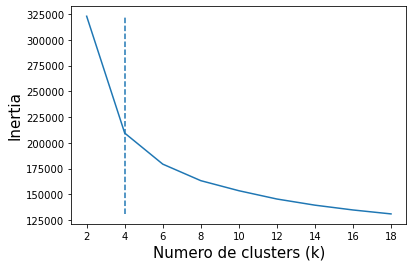

In [21]:
%matplotlib inline
plt.plot(k_values,inertia);
plt.vlines(4,np.min(inertia),np.max(inertia),linestyle='dashed');
plt.xlabel('Numero de clusters (k)',fontsize=15);plt.ylabel('Inertia',fontsize='15')

### Composición de los clusters

Veamos cómo están compuestos los clusters, por ejemplo mirando las posiciones preferibles para cada jugador. Esta información está en el campo 'Preferred position' del dataset original.

* Hagan un gráfico de barras para cada cluster mostrando la proporción de jugadores de cada posición que lo componen.

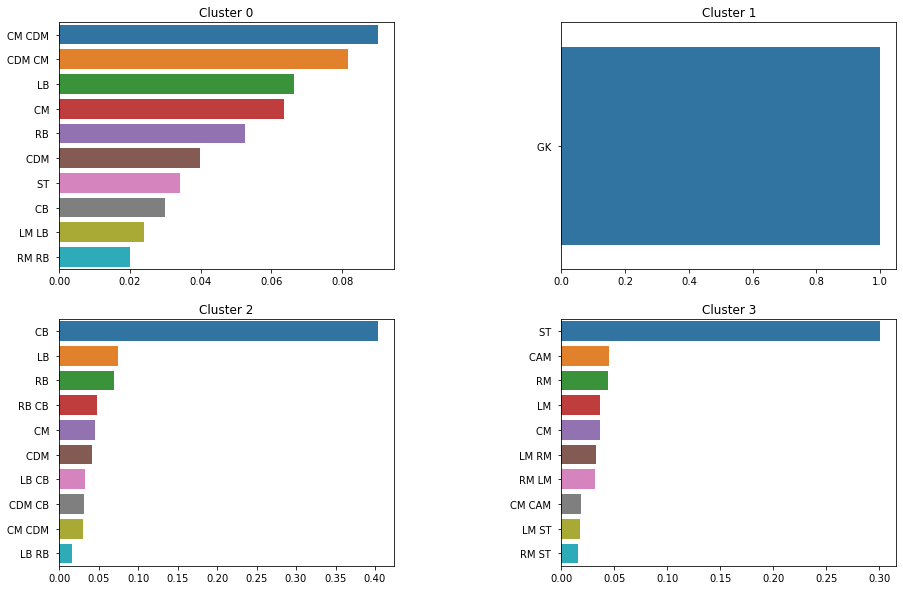

In [22]:
k=4;
km=KMeans(n_clusters=k,random_state=0)
km.fit(X)

data_filtered=data.loc[data_clustering.index];
f,ax=plt.subplots(2,2,figsize=(15,10),gridspec_kw={'wspace':0.5})
ax=ax.ravel();
for lbl in range(k):
    S=data_filtered.loc[km.labels_==lbl,'Preferred Positions'].value_counts(normalize=True);
    chart=sns.barplot(y=S.index[:10],x=S.values[:10],ax=ax[lbl],orient='h')
    chart.set_title('Cluster '+str(lbl))


### Más clusters

Vimos que los clusters contienen información sobre la posición en el campo. Si forzamos k = 15, 

* ¿se ven las posiciones pintadas de distinto color en la imagen de la introducción?

* Si encuentran clusters con una composición parecida de posiciones, ¿qué variable puede ser relevante para separarlos? Tal vez el valor... Grafiquen simultaneamente la distribución de valores de los jugadores para los clusters de composición similar.

In [23]:
k=15;
km=KMeans(n_clusters=k,random_state=0)
km.fit(X)

KMeans(n_clusters=15, random_state=0)

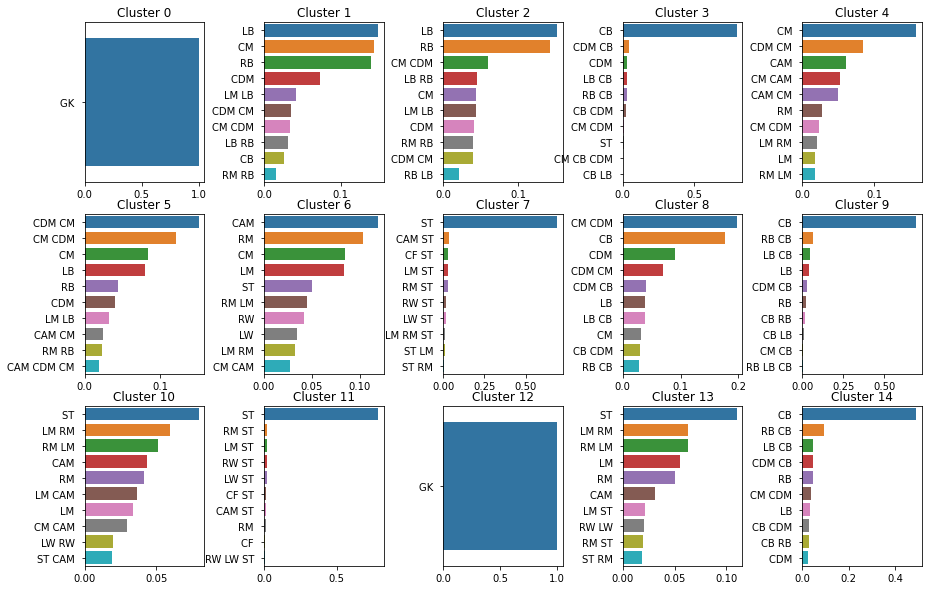

In [24]:
data_filtered=data.loc[data_clustering.index]
f,ax=plt.subplots(3,5,figsize=(15,10),gridspec_kw={'wspace':0.5})
ax=ax.ravel();
for lbl in range(k):
    S=data_filtered.loc[km.labels_==lbl,'Preferred Positions'].value_counts(normalize=True);
    chart=sns.barplot(y=S.index[:10],x=S.values[:10],ax=ax[lbl],orient='h')
    chart.set_title('Cluster '+str(lbl))    
    #chart.set_xticklabels(chart.get_xticklabels(), rotation=90);

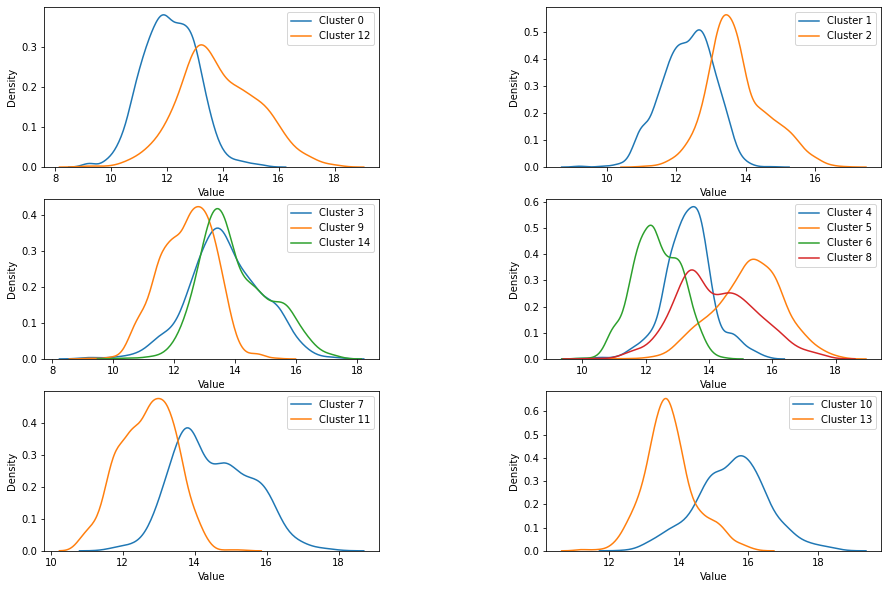

In [25]:
grupos=[[0,12],[1,2],[3,9,14],[4,5,6,8],[7,11],[10,13]];

f,ax=plt.subplots(3,2,figsize=(15,10),gridspec_kw={'wspace':0.5});
ax=ax.ravel();

for i,g in enumerate(grupos):
    for c in g:        
        values=data_filtered.loc[km.labels_==c,'Value'];                        
        sns.kdeplot(np.log(values),label='Cluster '+str(c),ax=ax[i]);        
    ax[i].legend();
    

### Visualización en un espacio de dimensionalidad reducida

* Reduzcamos la dimensionalidad del dataset usando PCA y conservando dos componentes principales.

* Grafiquemos con un scatterplot los 4 clusters obtenidos originalmente en este espacio reducido.

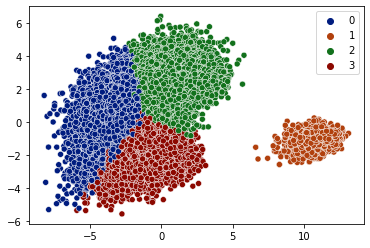

In [26]:
k=4;
km=KMeans(n_clusters=k,random_state=0)
km.fit(X)

pca=PCA(n_components=2)
X_transformed=pca.fit_transform(X)

sns.scatterplot(x = X_transformed[:,0], y = X_transformed[:,1],hue=km.labels_,palette='dark');
